In [350]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_curve

In [351]:
df = pd.read_csv("draft_df_cleaned.csv", index_col=0)
nomc_cols = ["ROTY", "PLAYER", "ROOKIE", "FTA", "AST", "DREB", "STL", "OREB", "GP", "BLK", "PF", "ThreePM", "FTPercent", \
             "ThreePPercent", "FGPercent", "GUARD", "FORWARD", "WEIGHT", "HEIGHT", "CENTER", "YEAR", "OVERALL PICK"]
df = df[nomc_cols]
cols_at_end = ['ROTY']
df = df[[c for c in df if c not in cols_at_end] 
        + [c for c in cols_at_end if c in df]]

df

,PLAYER,ROOKIE,FTA,AST,DREB,STL,OREB,GP,BLK,PF,...,ThreePPercent,FGPercent,GUARD,FORWARD,WEIGHT,HEIGHT,CENTER,YEAR,OVERALL PICK,ROTY
0,Kwame Brown,0,1.7,0.8,2.4,0.3,1.1,57.0,0.5,1.8,...,0.0,38.7,0,0,132.0,2.11,1,2001,1,0
1,Tyson Chandler,0,3.1,0.8,3.2,0.4,1.6,71.0,1.3,2.5,...,0.0,49.7,0,0,107.0,2.13,1,2001,2,0
2,Pau Gasol,0,5.8,2.7,6.0,0.5,2.9,82.0,2.1,2.4,...,20.0,51.8,0,1,113.0,2.13,1,2001,3,1
3,Jason Richardson,0,2.6,3.0,2.7,1.3,1.6,80.0,0.4,2.4,...,33.3,42.6,1,0,102.0,1.98,0,2001,5,0
4,Shane Battier,0,3.6,2.8,3.1,1.6,2.3,78.0,1.0,2.8,...,37.3,42.9,0,1,100.0,2.03,0,2001,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,Kendall Brown,1,2.2,1.9,3.1,1.0,1.7,34.0,0.4,2.3,...,34.1,58.4,1,0,93.0,2.03,0,2022,48,0
889,Isaiah Mobley,1,2.3,1.0,3.7,0.6,1.5,31.0,0.6,2.2,...,28.6,47.4,0,1,108.0,2.03,0,2022,49,0
890,Tyrese Martin,1,1.6,1.0,3.3,0.8,1.9,33.0,0.3,2.1,...,31.1,41.8,1,0,98.0,1.98,0,2022,51,0
891,JD Davison,1,2.5,4.3,3.7,1.0,1.1,33.0,0.4,1.2,...,30.1,46.3,1,0,88.0,1.91,0,2022,53,0


In [352]:
df_past = df[df['ROOKIE'] == 0]
df_past_quant = df_past.select_dtypes(include=np.number).drop("ROOKIE", axis=1)


In [353]:
df_tbd = df[df['ROOKIE'] == 1]
df_tbd_quant = df_tbd.select_dtypes(include=np.number).drop("ROOKIE", axis=1)

In [354]:
X = df_past_quant.drop("ROTY", axis=1)
y = df_past_quant["ROTY"]

In [355]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (570, 18) (570,)
Test (282, 18) (282,)


In [356]:
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

In [357]:
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

fs_dict = {"Features":df_past_quant.drop("ROTY", axis=1).columns, "Feature Score" : fs.scores_}
fs_df = pd.DataFrame(data=fs_dict).sort_values(by='Feature Score', ascending=False)

Feature 0: 80.476816
Feature 1: 61.944247
Feature 2: 38.084474
Feature 3: 23.102564
Feature 4: 16.005769
Feature 5: 8.294400
Feature 6: 13.080534
Feature 7: 6.393655
Feature 8: 10.768791
Feature 9: 1.850600
Feature 10: 0.005832
Feature 11: 0.233197
Feature 12: 0.023859
Feature 13: 0.004028
Feature 14: 0.064378
Feature 15: 0.379105
Feature 16: 0.113467
Feature 17: 14.999933


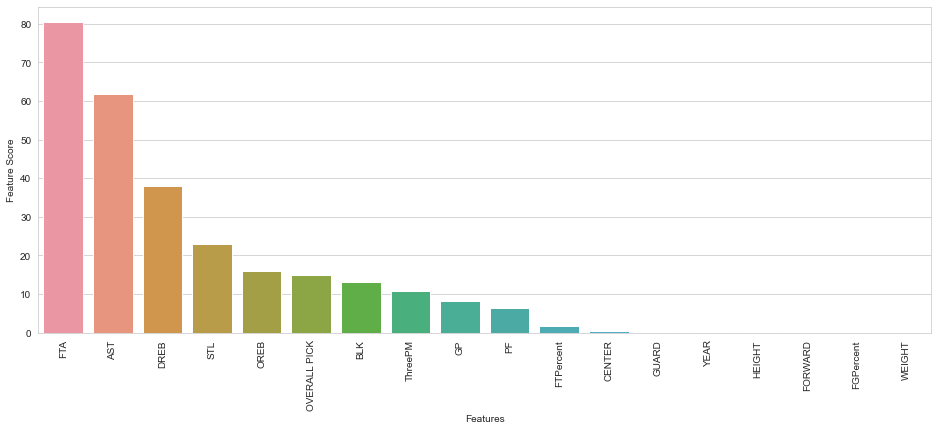

In [358]:
plt.figure(figsize=(16, 6))
bar = sns.barplot(x="Features", y="Feature Score", data=fs_df)
plt.xticks(rotation = 90)
plt.show()

In [359]:
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=chi2, k=10)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs

In [360]:
X_train_fs, X_test_fs = select_features(X_train, y_train, X_test)
model1 = LogisticRegression(solver='lbfgs', max_iter=1000)
model1.fit(X_train_fs, y_train)

LogisticRegression(max_iter=1000)

In [361]:
y_hat1 = model1.predict(X_test_fs)
chi_score = accuracy_score(y_test, y_hat1)

In [362]:
model2 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [363]:
y_hat2 = model2.predict(X_test)
xgb_score = accuracy_score(y_test, y_hat2) #high predicted accuracy due to small amount of rookie of the year winners

In [364]:
model3 = RandomForestClassifier(n_estimators=1000)
model3.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [365]:
y_hat3 = model3.predict(X_test)
rfr_score = accuracy_score(y_test, y_hat3)

In [366]:
print("Chi2 score: ", chi_score)
print("XGB score: ", xgb_score)
print("rfr_score: ", rfr_score)

Chi2 score:  0.9787234042553191
XGB score:  0.975177304964539
rfr_score:  0.9716312056737588


In [367]:
y_hats  = pd.DataFrame(data=y_hat1, index=X_test.index.copy(), columns=["PRED ROTY"])

In [368]:
y_apd = pd.merge(y_test, y_hats, right_index=True, left_index=True)

In [369]:
correct = 0
wrong = 0
missed = 0
clst = []
wlst = []
mlst = []
for index, row in y_apd.iterrows():
    if row['ROTY'] == 1 and row['PRED ROTY'] == 1:
        correct += 1
        clst += [df_past.loc[index, "PLAYER"]]
    elif row['ROTY'] == 0 and row['PRED ROTY'] == 1:
        wrong += 1
        wlst += [df_past.loc[index, "PLAYER"]]
    elif row['ROTY'] == 1 and row['PRED ROTY'] == 0:
        missed += 1
        mlst += [df_past.loc[index, "PLAYER"]]

print("correct: ", correct, clst)
print("wrong: ", wrong, wlst)
print("missed: ", missed, mlst)

correct:  2 ['Blake Griffin', 'Chris Paul']
wrong:  0 []
missed:  6 ['Karl-Anthony Towns', 'Brandon Roy', 'Ja Morant', 'Derrick Rose', "Amar'e Stoudemire", 'LeBron James']


In [370]:
weights = np.linspace(0.0,0.99,200) #Range for class weights
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]} 
#Dictionary for grid search

In [371]:
gridsearch = GridSearchCV(estimator= model1, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring="f1", 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\asimp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

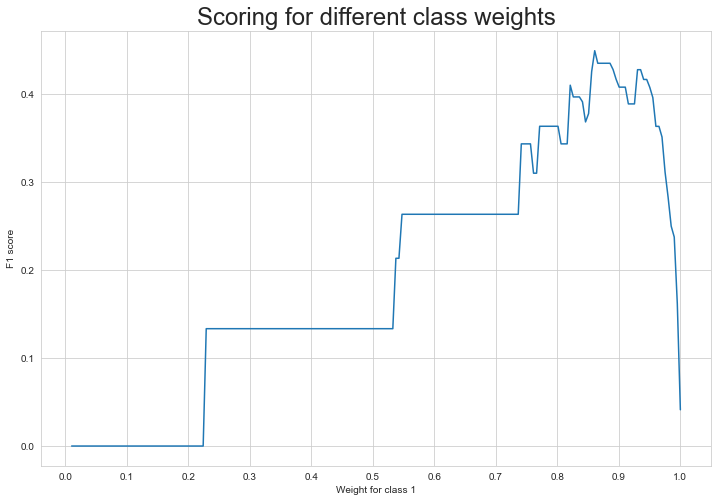

In [372]:
#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

In [373]:
gridsearch.best_estimator_

LogisticRegression(class_weight={0: 0.1392964824120603, 1: 0.8607035175879397},
                   max_iter=1000)

In [374]:
X_train_fs, X_test_fs = select_features(X_train, y_train, X_test)
model1v1 = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight={0: 0.1392964824120603, 1: 0.8607035175879397})
model1v1.fit(X_train_fs, y_train)

LogisticRegression(class_weight={0: 0.1392964824120603, 1: 0.8607035175879397},
                   max_iter=1000)

In [375]:
y_hatv1 = model1v1.predict(X_test_fs)

In [376]:
chi_scorev1 = accuracy_score(y_test, y_hatv1)
chi_scorev1 #changing class weights did not affect accuracy

0.9787234042553191

Best Threshold=0.559314, F-Score=0.842


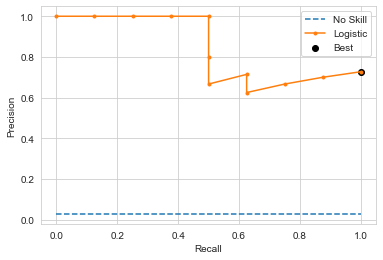

In [377]:
yv1_prob = model1v1.predict_proba(X_test_fs) #predicts probabilities for y_test
yv1_prob = yv1_prob[:, 1] #selects only ROTY's

precision, recall, thresholds = precision_recall_curve(y_test, yv1_prob)

fscore = (2 * precision * recall) / (precision + recall)

ix = argmax(fscore) # locate the index of the largest f score
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.show()

In [378]:
X_train_fs, X_test_fs = select_features(X_train, y_train, X_test)
model1v2 = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight={0: 0.1392964824120603, 1: 0.8607035175879397})
model1v2.fit(X_train_fs, y_train)

LogisticRegression(class_weight={0: 0.1392964824120603, 1: 0.8607035175879397},
                   max_iter=1000)

In [379]:
THRESHOLD = 0.559314,
y_hatv2 = np.where(model1v2.predict_proba(X_test_fs)[:,1] > THRESHOLD, 1, 0)

In [380]:
chi_scorev2 = accuracy_score(y_test, y_hatv2)
chi_scorev2

0.9893617021276596

In [381]:
y_hatsv2  = pd.DataFrame(data=y_hatv2, index=X_test.index.copy(), columns=["PRED ROTY"])

In [382]:
y_apdv2 = pd.merge(y_test, y_hatsv2, right_index=True, left_index=True)

In [383]:
correct = 0
wrong = 0
missed = 0
clst = []
wlst = []
mlst = []
for index, row in y_apdv2.iterrows():
    if row['ROTY'] == 1 and row['PRED ROTY'] == 1:
        correct += 1
        clst += [df_past.loc[index, "PLAYER"]]
    elif row['ROTY'] == 0 and row['PRED ROTY'] == 1:
        wrong += 1
        wlst += [df_past.loc[index, "PLAYER"]]
    elif row['ROTY'] == 1 and row['PRED ROTY'] == 0:
        missed += 1
        mlst += [df_past.loc[index, "PLAYER"]]

print("correct: ", correct, clst)
print("wrong: ", wrong, wlst)
print("missed: ", missed, mlst)

correct:  8 ['Karl-Anthony Towns', 'Blake Griffin', 'Brandon Roy', 'Ja Morant', 'Derrick Rose', 'Chris Paul', "Amar'e Stoudemire", 'LeBron James']
wrong:  3 ['Ramon Sessions', 'Marc Gasol', 'Carmelo Anthony']
missed:  0 []


PLAYER           Lavoy Allen
ROOKIE                     0
FTA                      0.3
AST                      0.8
DREB                     3.0
STL                      0.3
OREB                     1.1
GP                      41.0
BLK                      0.4
PF                       1.8
ThreePM                  0.0
FTPercent               78.6
ThreePPercent            0.0
FGPercent               47.3
GUARD                      0
FORWARD                    1
WEIGHT                 118.0
HEIGHT                  2.06
CENTER                     1
YEAR                    2011
OVERALL PICK              50
ROTY                       0
Name: 406, dtype: object